# Grupy-SP
## Combate à fraude com Deep Learning
### Carlos Baia - carlosbaia.com

# Dados

Os dados podem ser baixados em: https://www.kaggle.com/dalpozz/creditcardfraud

In [90]:
# Carregando os dados
import pandas as pd

df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [91]:
# Vendo as quantidades de cada classe
# 0 = Não fraude
# 1 = Fraude
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

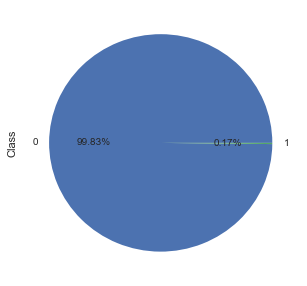

In [92]:
# Plotando essas quantidades
import matplotlib.pyplot as plt
%matplotlib inline

df.Class.value_counts().plot(kind='pie', autopct='%.2f%%', figsize=(5, 5));

In [93]:
# Plotando informações da base
print('Período: 2 dias em Setembro de 2013')
print('Transações:', len(df))
print('FRAUDES')
print(' Quantidade: ', df[df.Class == 1].Amount.count())
print(' Valor total: R$ {:8.2f}'.format(df[df.Class == 1].Amount.sum()))
print(' Valor médio: R$ {:8.2f}'.format(df[df.Class == 1].Amount.mean()))
print(' Valor maior: R$ {:8.2f}'.format(df[df.Class == 1].Amount.max()))

Período: 2 dias em Setembro de 2013
Transações: 284807
FRAUDES
 Quantidade:  492
 Valor total: R$ 60127.97
 Valor médio: R$   122.21
 Valor maior: R$  2125.87


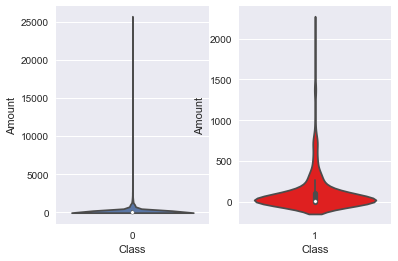

In [94]:
# Plotando distribuição dos valores entre as não fraudes (azul) e fraudes (vermelho)
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.violinplot('Class', 'Amount', data=df[df.Class == 0], ax=ax1)
sns.violinplot('Class', 'Amount', data=df[df.Class == 1], ax=ax2, color='red');

# Preparando os dados para o treinamento

In [95]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tflearn
import scipy.stats as ss

features = df.columns.drop(['Time', 'Class'])  # Removendo campos que não serão usandos como features
X = df[features].values                        # Jogando os valores da features em X
y = df.Class                                   # Jogando os valores da saídas em y

X_norm = ss.zscore(X, axis=1)                  # Aplicando Z-Score em X para normalizar os dados

# Divindo a base em 2 partes, uma para treinamento e outra para testar o treinamento.
# Isso é necessario, pois ao validar com dados que não usei para treinar tenho
# garantia de que não foi apenas uma memorização.
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.33, random_state=1986, stratify=y)

# Mudando formato da saída (y) para o esperado pela rede neural
targets = np.array([0, 1])
y_train2 = (y_train.values.reshape((-1, 1)) == targets).astype(np.uint8)
y_test2 = (y_test.values.reshape((-1, 1)) == targets).astype(np.uint8)

n_features = len(features)
print('Inputs:', n_features)
print('Features:', ' '.join(features))

Inputs: 29
Features: V1 V2 V3 V4 V5 V6 V7 V8 V9 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 V21 V22 V23 V24 V25 V26 V27 V28 Amount


## Aprendizado Supervisionado
### Classification
Usando as classificações que dizem ser fraude ou não para o treinamento

In [54]:
%%time
tf.reset_default_graph()

# Montando a arquitetura da rede, 4 camadas com 29-32-32-2 neuronios.
net = tflearn.input_data((None, n_features))
net = tflearn.fully_connected(net, 32, activation='tanh')
net = tflearn.dropout(net, 0.6)
net = tflearn.fully_connected(net, 32, activation='tanh')
net = tflearn.dropout(net, 0.6)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net, learning_rate=1e-3)
model = tflearn.DNN(net)

# Executando o treinamento, esse linha pode se repetida
# caso queira continuar o treinamento de onde parou.
model.fit(X_train, y_train2, n_epoch=50, batch_size=512, show_metric=True,
          validation_set=(X_test, y_test2), shuffle=True, run_id='classification')

Training Step: 18649  | total loss: 0.00516 | time: 4.001s
| Adam | epoch: 050 | loss: 0.00516 - acc: 0.9988 -- iter: 190464/190820
Training Step: 18650  | total loss: 0.00517 | time: 5.210s
| Adam | epoch: 050 | loss: 0.00517 - acc: 0.9985 | val_loss: 0.00339 - val_acc: 0.9993 -- iter: 190820/190820
--
Wall time: 6min 16s


In [55]:
from sklearn.metrics import confusion_matrix, f1_score

# Fazendo as predições na base de teste.
y_test_pred = model.predict(X_test)

# Gerando o F1 score para medir a eficiência.
# F1 Score vai de 0 até 1, sendo que 1 significa que acertou tudo.
print('F1 Score:', f1_score(np.argmax(y_test2, axis=1), np.argmax(y_test_pred, axis=1)))

# Gerando a matriz da confusão para ver os acertos e erros de cada classificação.
cm = confusion_matrix(np.argmax(y_test2, axis=1), np.argmax(y_test_pred, axis=1))

F1 Score: 0.790996784566


array([[93799,    26],
       [   39,   123]])

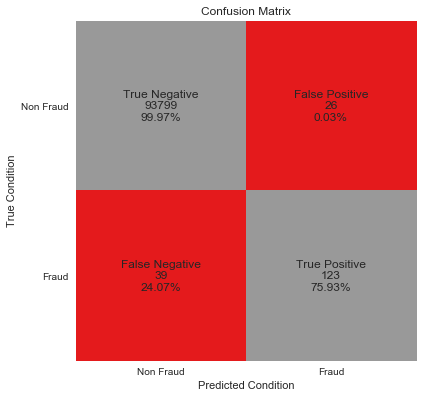

In [56]:
# Plotando a matriz da confusão
import itertools

def confusion_matrix(cm, ax, classes):
    ax.imshow(([[1, 0], [0, 1]]), interpolation='nearest', cmap=plt.cm.Set1)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.grid()
    ax.set_title('Confusion Matrix')
    ncm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    labels = [['True Negative', 'False Positive'], ['False Negative', 'True Positive']]
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, '%s\n%d\n%.2f%%' % (labels[i][j], cm[i, j], ncm[i, j]), horizontalalignment='center',
                verticalalignment='center')
    plt.tight_layout()
    ax.set_ylabel('True Condition')
    ax.set_xlabel('Predicted Condition')
    return ax

fig, ax = plt.subplots()
confusion_matrix(cm, ax, ['Non Fraud', 'Fraud']);

# Aprendizado Não Supervisionado
### Label Encoder
Sem usar as classificações que dizem ser fraude ou não para o treinamento, apenas para verificarmos no fim se ficou bom.

In [64]:
%%time
tf.reset_default_graph()

# Criando encoder
encoder = tflearn.input_data(shape=(None, n_features))
encoder = tflearn.fully_connected(encoder, 20, activation='tanh')
encoder = tflearn.fully_connected(encoder, 10, activation='tanh')
encoder = tflearn.fully_connected(encoder, 5, activation='tanh')

# Criando decoder
decoder = tflearn.fully_connected(encoder, 10, activation='tanh')
encoder = tflearn.fully_connected(decoder, 20, activation='tanh')
decoder = tflearn.fully_connected(decoder, n_features, activation='tanh')

# Regression, usando métrica mean square error
net = tflearn.regression(decoder, optimizer='adam', learning_rate=0.01, loss='mean_square', metric=None)
model = tflearn.DNN(net)

# Executando o treinamento
model.fit(X_norm, X_norm, n_epoch=15, batch_size=512, show_metric=True, shuffle=True, run_id='auto_encoder')

Training Step: 16709  | total loss: 0.57613 | time: 3.576s
| Adam | epoch: 030 | loss: 0.57613 -- iter: 284672/284807
Training Step: 16710  | total loss: 0.57593 | time: 3.582s
| Adam | epoch: 030 | loss: 0.57593 -- iter: 284807/284807
--
Wall time: 1min 34s


In [89]:
# Usando modelo treinado
X_norm_pred = model.predict(X_norm)

# Pegando os erros, os maiores tendem a ser quem foge do padrão.
errors = np.mean((X_norm - X_norm_pred)**2, axis=1)

def show_stats(indexes):
    class_counts = pd.value_counts(y)
    pred_class_counts = pd.value_counts(y[indexes])
    return pd.concat((class_counts,
                      pred_class_counts,
                      100 * pred_class_counts / class_counts),
                     keys=['Class Count', 'Predicted Class Count', 'Hit Rate'],
                     axis=1)


def show_stats_of_highest_errors(number_of_values):
    threshold_index = int(len(errors) - number_of_values)
    threshold_value = np.sort(errors)[threshold_index]
    print('Threshold: ', threshold_value)
    indexes = np.where(errors >= threshold_value)[0]
    return show_stats(indexes)

# Imprimindo os 3% maiores erros e achamos 50% das fraude ali
show_stats_of_highest_errors(len(errors) * 0.03)

Threshold:  0.644575454986


,Class Count,Predicted Class Count,Hit Rate
0,284315,8291,2.916132
1,492,254,51.626016


In [67]:
# Pegando 100 amostras aleatórios e dificilmente vem fraude, pois é apenas 0.17% da base.
show_stats(df.sample(100).index).fillna(0)

,Class Count,Predicted Class Count,Hit Rate
0,284315,100.0,0.035172
1,492,0.0,0.000000


In [82]:
# Pegando os 100 maiores erros e temos 27 fraudes :)
show_stats_of_highest_errors(100)

Threshold:  0.986156039278


,Class Count,Predicted Class Count,Hit Rate
0,284315,73,0.025676
1,492,27,5.487805


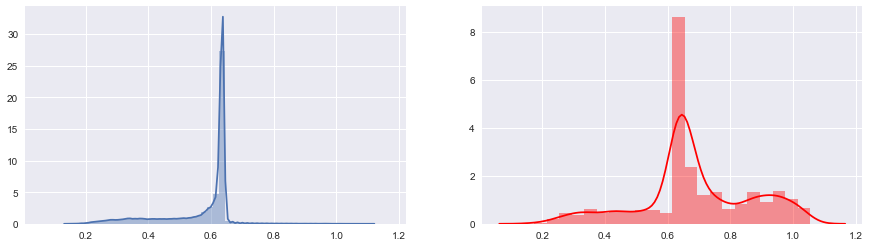

In [73]:
# Plotando a distribuição dos erros das não fraudes (azul) e das fraudes (vermelho).
# Podemos notar que existe uma separação próximo ao erro de 0.6.
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
sns.distplot(errors[np.where(y == 0)], ax=ax1)
sns.distplot(errors[np.where(y == 1)], ax=ax2, color='r');